<a href="https://colab.research.google.com/github/AyushPantOfficial/Resume-classifier/blob/main/assignment_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
import re
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
df = pd.read_csv('/kaggle/input/resume-dataset/Resume/Resume.csv')
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [ ]:
#dropping the columns not gonna use
df.drop(columns=['ID','Resume_html'],inplace=True)
df

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
2479,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION
2480,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION
2481,GEEK SQUAD AGENT Professional...,AVIATION
2482,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION


### DATA PREPROCESSING

In [ ]:
#STEMMING
ps = nltk.stem.porter.PorterStemmer()

In [ ]:
def preprocess(txt):
    # convert all characters in the string to lower case
    txt = txt.lower()
    # remove non-english characters, punctuation and numbers
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    # tokenize word
    txt = nltk.tokenize.word_tokenize(txt)
    # remove stop words
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]
    # stemming
    txt = [ps.stem(w) for w in txt]

    return ' '.join(txt)

In [ ]:
df['Resume'] = df['Resume_str'].apply(lambda w: preprocess(w))
# drop original text column
df.pop('Resume_str')
df

,Category,Resume
0,HR,hr administr market associ hr administr summar...
1,HR,hr specialist us hr oper summari versatil medi...
2,HR,hr director summari year experi recruit plu ye...
3,HR,hr specialist summari dedic driven dynam year ...
4,HR,hr manag skill highlight hr skill hr depart st...
...,...,...
2479,AVIATION,rank sgt e non commiss offic charg brigad mail...
2480,AVIATION,govern relat commun organiz develop director p...
2481,AVIATION,geek squad agent profession profil support spe...
2482,AVIATION,program director offic manag summari highli pe...


### Exploratory Data Analysis

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  2484 non-null   object
 1   Resume    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [ ]:
df['Category'].unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

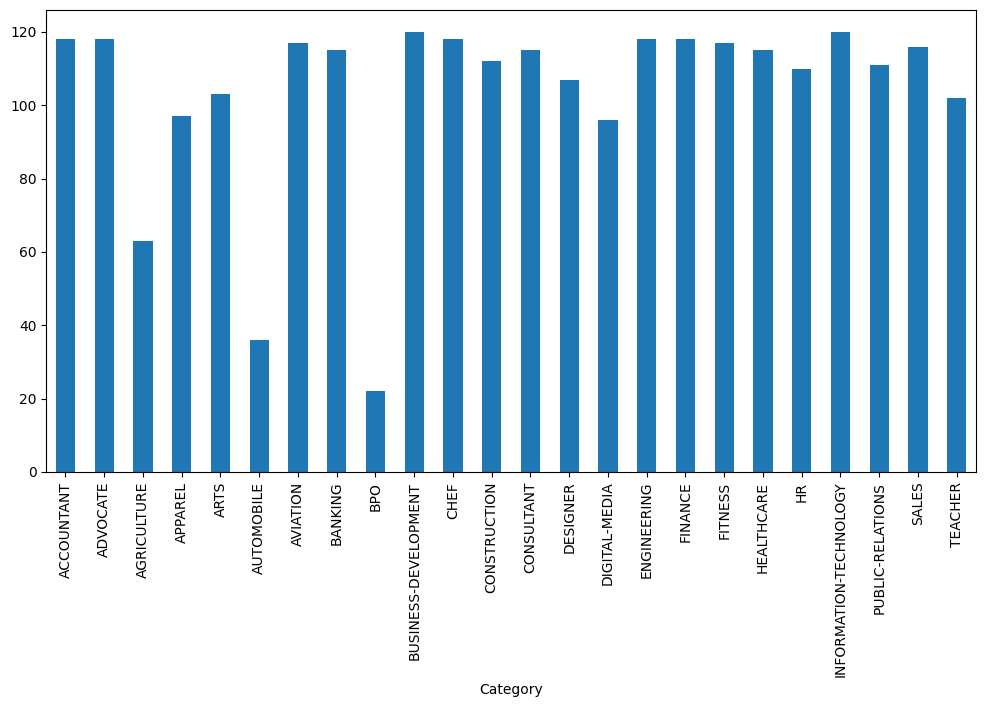

In [ ]:
df['Category'].value_counts().sort_index().plot(kind='bar', figsize=(12, 6))
plt.show()

In [ ]:
# create list of all categories
categories = np.sort(df['Category'].unique())
categories

array(['ACCOUNTANT', 'ADVOCATE', 'AGRICULTURE', 'APPAREL', 'ARTS',
       'AUTOMOBILE', 'AVIATION', 'BANKING', 'BPO', 'BUSINESS-DEVELOPMENT',
       'CHEF', 'CONSTRUCTION', 'CONSULTANT', 'DESIGNER', 'DIGITAL-MEDIA',
       'ENGINEERING', 'FINANCE', 'FITNESS', 'HEALTHCARE', 'HR',
       'INFORMATION-TECHNOLOGY', 'PUBLIC-RELATIONS', 'SALES', 'TEACHER'],
      dtype=object)

In [ ]:
# create new df for corpus and category
df_categories = [df[df['Category'] == category].loc[:, ['Resume', 'Category']] for category in categories]
df_categories[10]

,Resume,Category
1357,chef career focu nurs student recent obtain cn...,CHEF
1358,chef summari custom orient fast food worker de...,CHEF
1359,chef career overview dedic custom servic repre...,CHEF
1360,chef summari experienc cater chef skill prepar...,CHEF
1361,rm roxann mejia summari motiv chef compet keep...,CHEF
...,...,...
1470,owner chef summari chef year critic acclaim wo...,CHEF
1471,kindergarten teacher profession summari energe...,CHEF
1472,substitut para profession summari profession m...,CHEF
1473,execut chef partner summari proven abil fine d...,CHEF


In [ ]:
# word frequency for each category
def wordfreq(df):
    count = df['Resume'].str.split(expand=True).stack().value_counts().reset_index()
    count.columns = ['Word', 'Frequency']

    return count.head(10)

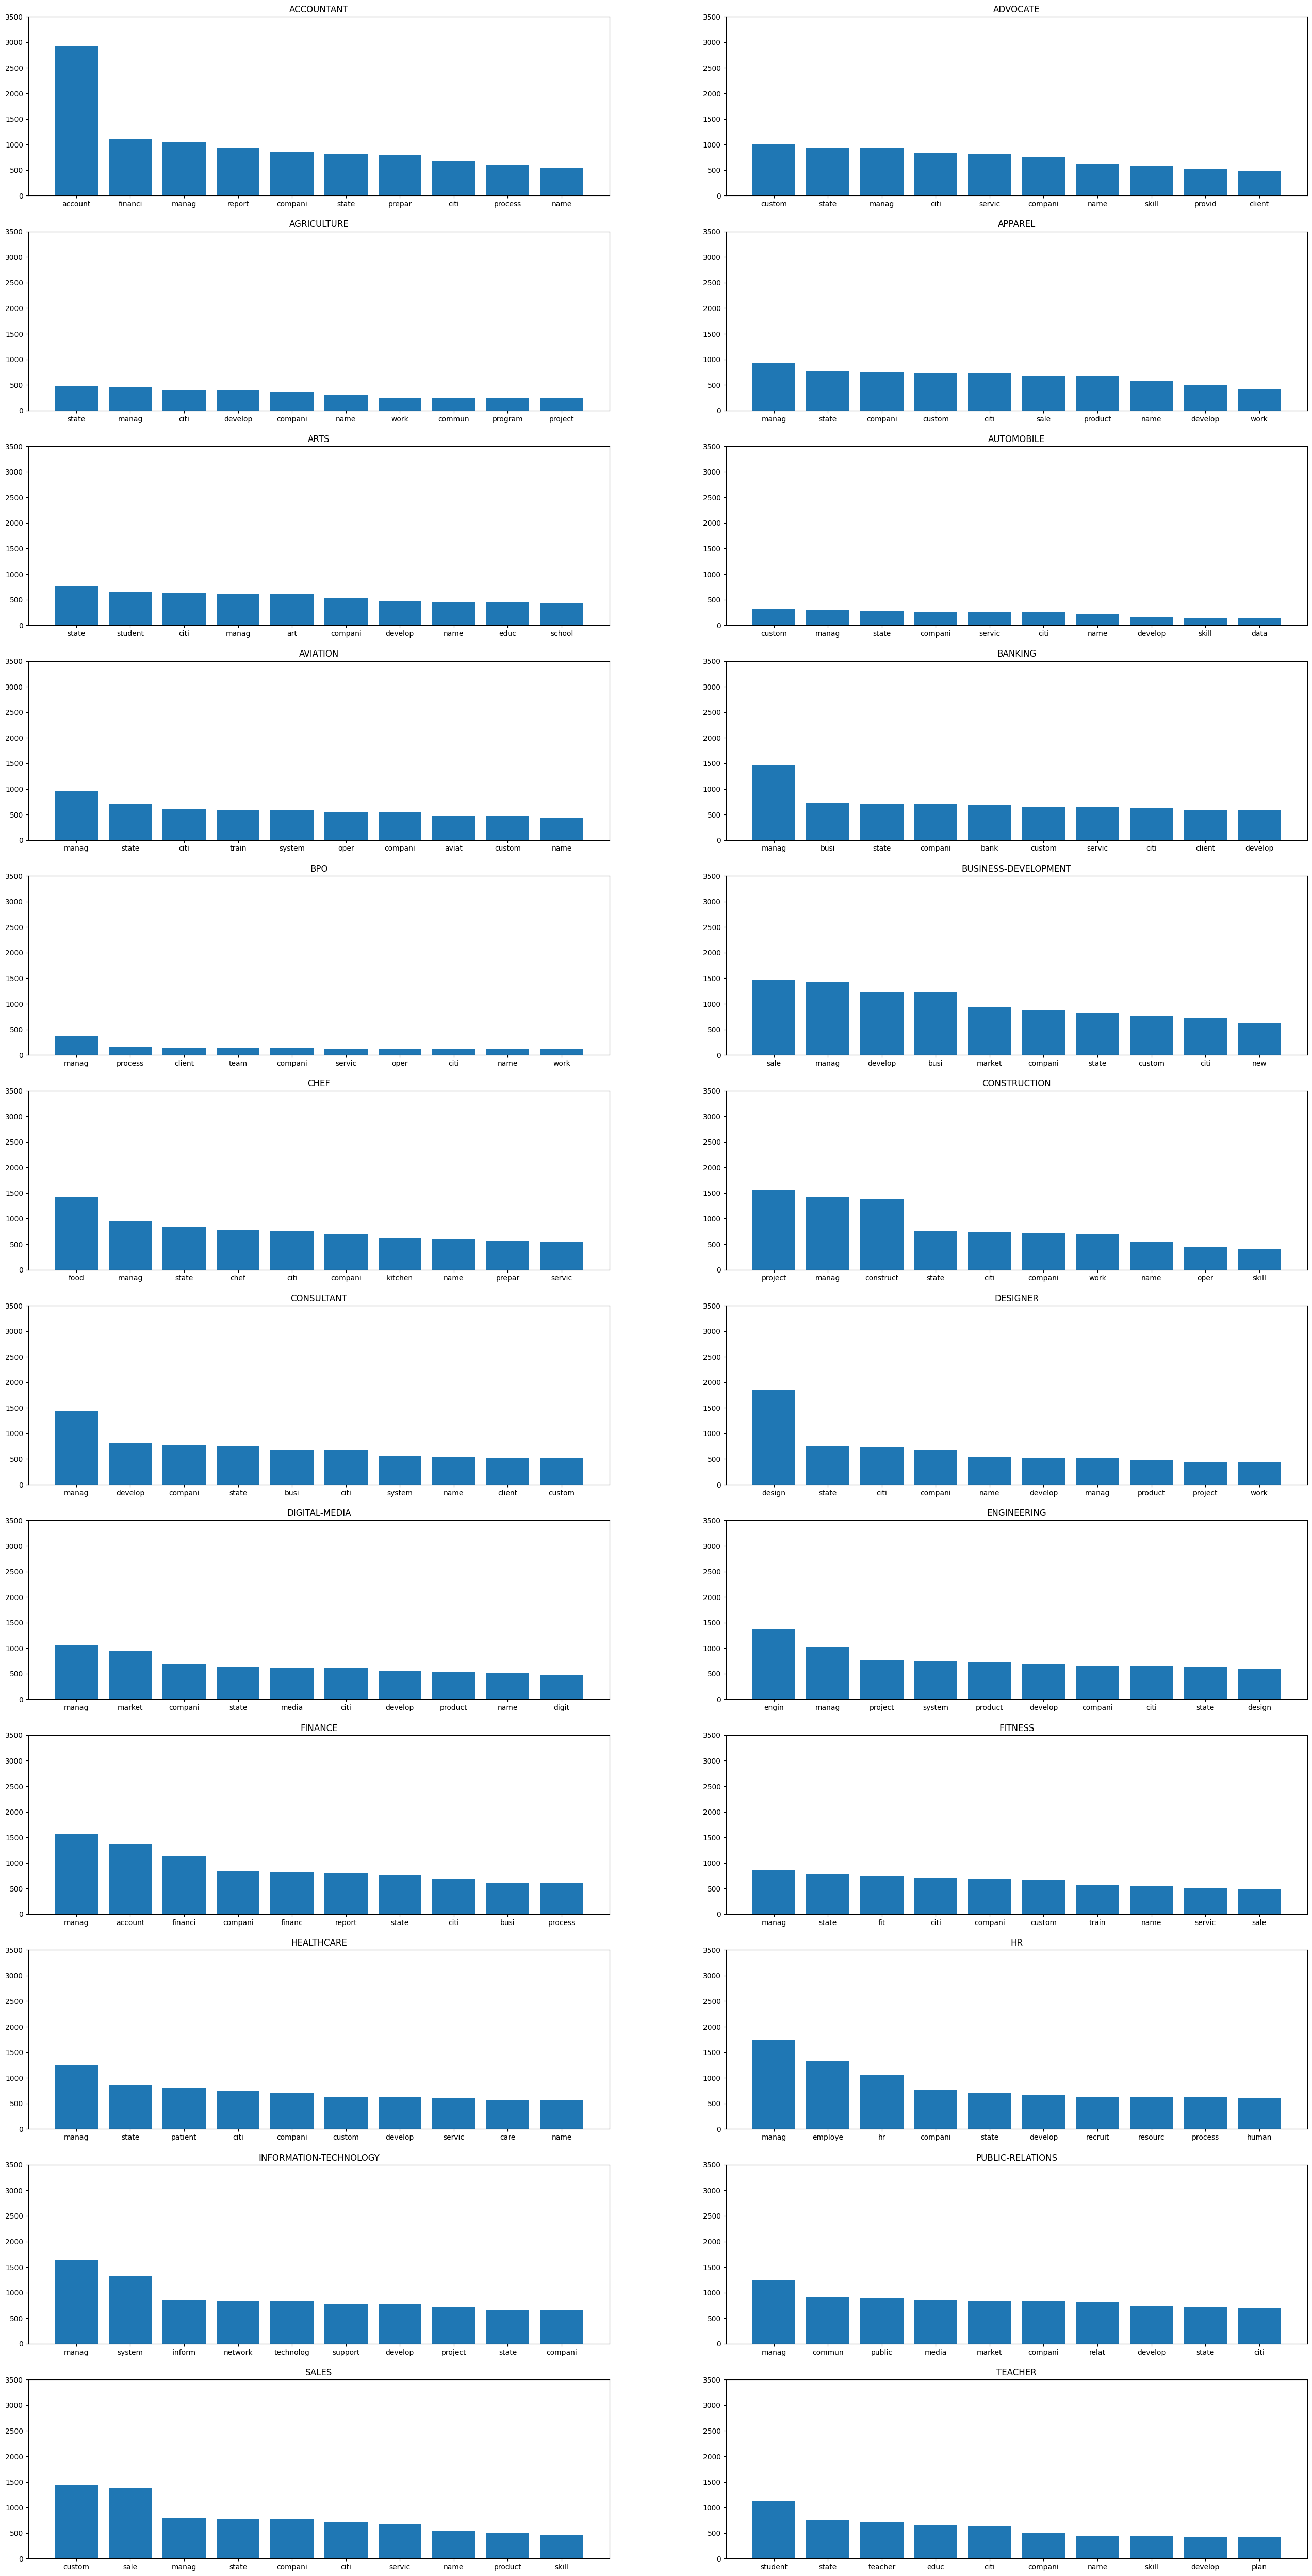

In [ ]:
fig = plt.figure(figsize=(32, 64))

for i, category in enumerate(np.sort(df['Category'].unique())):
    wf = wordfreq(df_categories[i])

    fig.add_subplot(12, 2, i + 1).set_title(category)
    plt.bar(wf['Word'], wf['Frequency'])
    plt.ylim(0, 3500)

plt.show()
plt.close()

### Data Cleaning

In [ ]:
from nltk.corpus import stopwords

In [ ]:
#defining stopwords
stop_words = stopwords.words('english')

In [ ]:
#function which stop words and the words less than 2 characters
def remove_stop_words (text):
  result = []
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
      result.append(token)

  return result

In [ ]:
df['clean'] = df['Resume'].apply(remove_stop_words).astype(str)

In [ ]:
df['clean'][0]

"['administr', 'market', 'associ', 'administr', 'summari', 'dedic', 'custom', 'servic', 'manag', 'year', 'experi', 'hospit', 'custom', 'servic', 'manag', 'respect', 'builder', 'leader', 'custom', 'focus', 'team', 'strive', 'instil', 'share', 'enthusiast', 'commit', 'custom', 'servic', 'highlight', 'focus', 'custom', 'satisfact', 'team', 'manag', 'market', 'savvi', 'conflict', 'resolut', 'techniqu', 'train', 'develop', 'skill', 'multi', 'tasker', 'client', 'relat', 'specialist', 'accomplish', 'missouri', 'supervisor', 'train', 'certif', 'certifi', 'custom', 'loyalti', 'market', 'segment', 'hilton', 'worldwid', 'gener', 'manag', 'train', 'certif', 'accomplish', 'trainer', 'cross', 'server', 'hospit', 'hilton', 'micro', 'opera', 'fidelio', 'opera', 'reserv', 'holidex', 'complet', 'cours', 'seminar', 'custom', 'servic', 'sale', 'strategi', 'inventori', 'control', 'loss', 'prevent', 'safeti', 'time', 'manag', 'leadership', 'perform', 'assess', 'experi', 'administr', 'market', 'associ', 'adm

In [ ]:
df

,Category,Resume,clean
0,HR,hr administr market associ hr administr summar...,"['administr', 'market', 'associ', 'administr',..."
1,HR,hr specialist us hr oper summari versatil medi...,"['specialist', 'oper', 'summari', 'versatil', ..."
2,HR,hr director summari year experi recruit plu ye...,"['director', 'summari', 'year', 'experi', 'rec..."
3,HR,hr specialist summari dedic driven dynam year ...,"['specialist', 'summari', 'dedic', 'driven', '..."
4,HR,hr manag skill highlight hr skill hr depart st...,"['manag', 'skill', 'highlight', 'skill', 'depa..."
...,...,...,...
2479,AVIATION,rank sgt e non commiss offic charg brigad mail...,"['rank', 'commiss', 'offic', 'charg', 'brigad'..."
2480,AVIATION,govern relat commun organiz develop director p...,"['govern', 'relat', 'commun', 'organiz', 'deve..."
2481,AVIATION,geek squad agent profession profil support spe...,"['geek', 'squad', 'agent', 'profession', 'prof..."
2482,AVIATION,program director offic manag summari highli pe...,"['program', 'director', 'offic', 'manag', 'sum..."


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df['clean'], df['Category'], test_size = 0.2)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer


# vectorize text data
vectorizer = CountVectorizer()
conuntvectorizer_train = vectorizer.fit_transform(X_train).astype(float)
conuntvectorizer_test = vectorizer.transform(X_test).astype(float)



In [ ]:


# using grid search for find optimal values for RF classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

RFC = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5, scoring='accuracy', return_train_score=False, verbose=1)
grid_search = grid.fit(conuntvectorizer_train, Y_train)

print(grid_search.best_params_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 500}


In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_Model = RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 500, max_depth=8, criterion='gini')
RF_Model.fit(conuntvectorizer_train, Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_depth=8, max_features='auto', n_estimators=500,
                       random_state=42)

In [ ]:
prediction=RF_Model.predict(conuntvectorizer_test)
prediction

array(['PUBLIC-RELATIONS', 'FITNESS', 'ADVOCATE', 'SALES', 'BANKING',
       'SALES', 'TEACHER', 'BANKING', 'ADVOCATE', 'SALES',
       'BUSINESS-DEVELOPMENT', 'INFORMATION-TECHNOLOGY', 'CHEF',
       'ACCOUNTANT', 'BUSINESS-DEVELOPMENT', 'TEACHER', 'AVIATION',
       'BUSINESS-DEVELOPMENT', 'PUBLIC-RELATIONS', 'ADVOCATE', 'CHEF',
       'FINANCE', 'TEACHER', 'ENGINEERING', 'HEALTHCARE', 'CONSTRUCTION',
       'DIGITAL-MEDIA', 'BANKING', 'INFORMATION-TECHNOLOGY',
       'INFORMATION-TECHNOLOGY', 'TEACHER', 'INFORMATION-TECHNOLOGY',
       'SALES', 'FITNESS', 'ENGINEERING', 'FITNESS', 'SALES', 'SALES',
       'BUSINESS-DEVELOPMENT', 'INFORMATION-TECHNOLOGY', 'AVIATION',
       'ACCOUNTANT', 'FINANCE', 'TEACHER', 'BANKING', 'CONSTRUCTION',
       'ENGINEERING', 'ACCOUNTANT', 'SALES', 'SALES',
       'BUSINESS-DEVELOPMENT', 'PUBLIC-RELATIONS', 'TEACHER',
       'ENGINEERING', 'PUBLIC-RELATIONS', 'BUSINESS-DEVELOPMENT', 'HR',
       'ENGINEERING', 'BANKING', 'HEALTHCARE', 'ACCOUNTANT', 'AC

In [ ]:
print("training Score: {:.2f}".format(RF_Model.score(conuntvectorizer_train, Y_train)))
print("test Score: {:.2f}".format(RF_Model.score(conuntvectorizer_test, Y_test)))

training Score: 0.86
test Score: 0.52
